# Bài 3

In [ ]:
!ls / /

/:
bin			    dev     lib32   NGC-DL-CONTAINER-LICENSE  root  tmp
boot			    etc     lib64   opt			      run   tools
content			    home    libx32  proc		      sbin  usr
cuda-keyring_1.0-1_all.deb  kaggle  media   python-apt		      srv   var
datalab			    lib     mnt     python-apt.tar.xz	      sys

/:
bin			    dev     lib32   NGC-DL-CONTAINER-LICENSE  root  tmp
boot			    etc     lib64   opt			      run   tools
content			    home    libx32  proc		      sbin  usr
cuda-keyring_1.0-1_all.deb  kaggle  media   python-apt		      srv   var
datalab			    lib     mnt     python-apt.tar.xz	      sys


In [ ]:
import kagglehub

data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to dataset files:",data_dir)

100%|██████████| 1.03G/1.03G [00:14<00:00, 76.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torch.nn.functional as F
import tqdm.notebook as tqdm
import matplotlib.patches as patches

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights, ResNet50_Weights

In [ ]:
class MyDataset(Dataset):
  def __init__(self,annotations_dir,image_dir,transform = None):
    self.annotations_dir = annotations_dir
    self.image_dir = image_dir
    self.transform = transform
    self.image_files = self.filter_images_with_multiple_objects()
  def filter_images_with_multiple_objects(self):
    valid_image_files = []
    for f in os.listdir(self.image_dir):
      if os.path.isfile(os.path.join(self.image_dir,f)):
        img_name = f
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir,annotation_name)

        if self.count_objects_in_annotation(annotation_path) ==1:
          valid_image_files.append(img_name)
    return valid_image_files
  def count_objects_in_annotation(self,annotation_path):
    try:
      tree = ET.parse(annotation_path)
      root = tree.getroot()
      count = 0
      for obj in root.findall("object"):
        count+=1
      return count
    except FileNotFoundError:
      return 0
  def __len__(self):
    return len(self.image_files)
  def __getitem__(self,idx):
    img1_file = self.image_files[idx]
    img1_path = os.path.join(self.image_dir,img1_file)
    annotation_name = os.path.splitext(img1_file)[0] + ".xml"
    img1_annotations = self.parse_annotation(os.path.join(self.annotations_dir,annotation_name))

    idx2 = random.randint(0,len(self.image_files)-1)
    img2_file =self.image_files[idx2]
    img2_path = os.path.join(self.image_dir,img2_file)
    annotation_name = os.path.splitext(img2_file)[0] + ".xml"
    img2_annotations = self.parse_annotation(os.path.join(self.annotations_dir,annotation_name))

    img1 = Image.open(img1_path).convert("RGB")
    img2 = Image.open(img1_path).convert("RGB")

    merged_image = Image.new("RGB",(img1.width+img2.width,max(img1.height,img2.height)))
    merged_image.paste(img1,(0,0))
    merged_image.paste(img2,(img1.width,0))
    merged_w = img1.width+img2.width
    merged_h = max(img1.height,img2.height)
    merged_annotations = []

    merged_annotations.append(
        {"bbox":img1_annotations[1].tolist(),"label":img1_annotations[0]}
    )

    new_bbox = [
        (img2_annotations[1][0]*img2.width+img1.width)/merged_w,
        (img2_annotations[1][1]*img2.height)/merged_h,
        (img2_annotations[1][2]*img2.width+img1.width)/merged_w,
        (img2_annotations[1][3]*img2.height)/merged_h
    ]
    merged_annotations.append(
        {"bbox":new_bbox,"label":img2_annotations[0]}
    )
    if self.transform:
      merged_image = self.transform(merged_image)
    else:
      merged_image = transforms.ToTensor()(merged_image)
    annotations = torch.zeros((len(merged_annotations),5))
    for i,ann in enumerate(merged_annotations):
      annotations[i] = torch.cat((torch.tensor(ann['bbox']),torch.tensor([ann['label']])))
    return merged_image,annotations
  def parse_annotation(self,annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    image_width = int(root.find("size/width").text)
    image_height = int(root.find("size/height").text)
    label = None
    bbox = None
    for obj in root.findall("object"):
      name = obj.find("name").text
      if ( label is None):
        label = name

        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)

        bbox = [
          xmin/image_width,
          ymin/image_height,
          xmax/image_width,
          ymax/image_height
        ]
    label_num = 0 if label ==" cat" else 1 if label =="dog" else 2

    return label_num,torch.tensor(bbox,dtype=torch.float32)


In [ ]:
annotations_dir = os.path.join(data_dir,"annotations")
image_dir = os.path.join(data_dir,"images")
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
dataset = MyDataset(annotations_dir,image_dir,transform=transform)
train_dataset,val_dataset = train_test_split(dataset,test_size=0.2)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [ ]:
class SimpleYOLO(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    self.num_classes = num_classes

    self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

    self.fcs = nn.Linear(
        2048,2*2*(4+self.num_classes)
    )

  def forward(self,x):
    features = self.backbone(x)
    features = F.adaptive_avg_pool2d(features,(1,1))
    features =features.view(features.size(0),-1)
    features=self.fcs(features)
    return features

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
class_to_idx = {"dog":0,"cat":1,"none":2}
model = SimpleYOLO(num_classes).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.7MB/s]


In [ ]:
def calculate_loss(output,targets,device,num_classes):
  mse_loss = nn.MSELoss()
  total_loss = 0
  batch_size = output.shape[0]
  ce_loss = nn.CrossEntropyLoss()
  batch_size = output.shape[0]
  output = output.view(batch_size,2,2,4+num_classes)
  for i in range(batch_size):
    for j in range(len(targets[i])):
      bbox_center_x = (targets[i][j][0] + targets[i][j][2])/2
      bbox_center_y = (targets[i][j][1]+targets[i][j][3])/2

      grid_x  =int(bbox_center_x*2)
      grid_y = int(bbox_center_y*2)

      label_one_hot = torch.zeros(num_classes,device=device)
      label_one_hot[int(targets[i][j][4])] =1

      classification_loss = ce_loss(output[i,grid_y,grid_x,4:],label_one_hot)

      bbox_target = targets[i][j][:4].to(device)
      regression_loss = mse_loss(output[i,grid_y,grid_x,:4],bbox_target)

      no_obj_loss = 0
      for other_grid_y in range(2):
        for other_grid_x in range(2):
          if other_grid_y != grid_y or other_grid_x != grid_x:
            no_obj_loss += mse_loss(output[i,other_grid_y,other_grid_x,:4],torch.zeros(4,device=device))
      total_loss+=classification_loss+regression_loss+no_obj_loss
  return total_loss/batch_size


In [ ]:
def evaluate_model(model,data_loader,device,num_classes):
  model.eval()
  running_loss =0.0
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    for images,targets in tqdm.tqdm(data_loader,desc="Validation",leave=False):
      images = images.to(device)
      output = model(images)
      total_loss = calculate_loss(output,targets,device,num_classes)
      running_loss+=total_loss.item()
      output  =output.view(images.shape[0],2,2,4+num_classes)
      for batch_idx in range(images.shape[0]):
        for target in targets[batch_idx]:

          bbox_center_x = (target[0]+target[2])/2
          bbox_center_y = (target[1]+target[3])/2
          grid_x = int(bbox_center_x*2)
          grid_y = int(bbox_center_y*2)

          prediction = output[batch_idx,grid_y,grid_x,4:].argmax().item()

          all_predictions.append(prediction)
          all_targets.append(target[4].item())
  val_loss = running_loss/len(data_loader)

  all_predictions = torch.tensor(all_predictions,device=device)
  all_targets = torch.tensor(all_targets,device=device)

  val_accuracy = (all_predictions==all_targets).float().mean()
  return val_loss,val_accuracy.item()
def train_model(model,train_loader,val_loader,optimizer,num_epochs,device,num_classes):
  best_val_accuracy = 0.0
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  for epoch in tqdm.tqdm(range(num_epochs),desc="Epochs"):
    model.train()
    running_loss =0.0
    for images,targets in tqdm.tqdm(train_loader,desc="Batches",leave=False):
      images = images.to(device)
      optimizer.zero_grad()
      output = model(images)

      total_loss = calculate_loss(output,targets,device,num_classes)

      total_loss.backward()
      optimizer.step()
      running_loss+=total_loss.item()
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss)

    epoch_loss = running_loss/len(train_loader)
    train_losses.append(epoch_loss)
    val_loss, val_accuracy = evaluate_model(model,val_loader,device,num_classes)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs},Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(model.state_dict(),"best_model.pth")
  return train_losses,val_losses,train_accuracies,val_accuracies

In [ ]:
train_model(model,train_loader,val_loader,optimizer,10,device,3)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/10,Train Loss: 1.4719, Validation Loss: 1.4138, Validation Accuracy: 0.7300


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/10,Train Loss: 1.2475, Validation Loss: 1.2966, Validation Accuracy: 0.7666


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/10,Train Loss: 1.1846, Validation Loss: 1.5051, Validation Accuracy: 0.7069


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/10,Train Loss: 1.1317, Validation Loss: 1.3258, Validation Accuracy: 0.7476


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/10,Train Loss: 1.0100, Validation Loss: 1.3398, Validation Accuracy: 0.7598


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/10,Train Loss: 0.9570, Validation Loss: 1.4358, Validation Accuracy: 0.7313


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/10,Train Loss: 0.9100, Validation Loss: 1.4448, Validation Accuracy: 0.7497


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/10,Train Loss: 0.8116, Validation Loss: 1.5613, Validation Accuracy: 0.7510


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/10,Train Loss: 0.7399, Validation Loss: 1.6044, Validation Accuracy: 0.7395


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/10,Train Loss: 0.6746, Validation Loss: 1.5457, Validation Accuracy: 0.7612


([1.4719264904658,
  1.4719264904658,
  1.2474873463312786,
  1.2474873463312786,
  1.1845859417351343,
  1.1845859417351343,
  1.1316846256615014,
  1.1316846256615014,
  1.0100221396774374,
  1.0100221396774374,
  0.9570319191102059,
  0.9570319191102059,
  0.9100188061755191,
  0.9100188061755191,
  0.8115769393982426,
  0.8115769393982426,
  0.7399029850318868,
  0.7399029850318868,
  0.6745511966366922,
  0.6745511966366922],
 [1.4138004730145137,
  1.2966189533472061,
  1.5051166514555614,
  1.325832759340604,
  1.339771608511607,
  1.4357656588157017,
  1.4447546601295471,
  1.561269814769427,
  1.6044352253278096,
  1.5456936409076054],
 [],
 [0.7299864292144775,
  0.766621470451355,
  0.7069199681282043,
  0.7476255297660828,
  0.7598372101783752,
  0.7313432693481445,
  0.7496607899665833,
  0.7510176301002502,
  0.739484429359436,
  0.7611940503120422])

<ipython-input-20-ed254eb98d81>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


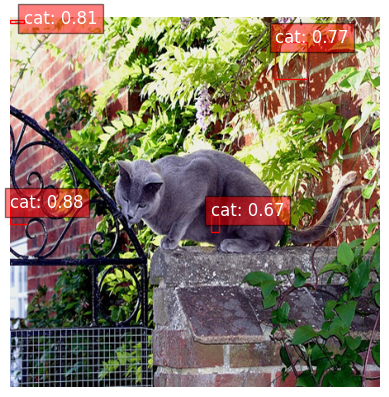

In [ ]:
def inference(model,image_path,device,class_to_idx,threshold=0.5):
  model.eval()
  image = Image.open(image_path).convert("RGB")
  original_width,original_height = image.size

  resized_image = image.resize((448,448))
  resized_width,resized_height =resized_image.size

  transformed_image = transform(resized_image).unsqueeze(0).to(device)

  with torch.no_grad():
    output = model(transformed_image)
    output = output.view(1,2,2,4+len(class_to_idx))
  fig,ax = plt.subplots(1)
  ax.axis("off")
  ax.imshow(resized_image)
  for grid_y in range(2):
    for grid_x in range(2):

      class_pred = output[0,grid_y,grid_x,4:].argmax().item()

      bbox = output[0,grid_y,grid_x,:4].tolist()

      confidence = torch.softmax(output[0,grid_y,grid_x,4:],dim=0)[class_pred].item()

      x_min = bbox[0]*(resized_width/2)+grid_x*(resized_width/2)
      y_min = bbox[1]*(resized_height/2)+grid_y*(resized_height/2)
      x_max = bbox[2]*(resized_width/2)+grid_x*(resized_width/2)
      y_max = bbox[3]*(resized_height/2)+grid_y*(resized_height/2)

      if confidence > threshold:
        rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1,edgecolor="r",facecolor="none")
        ax.add_patch(rect)
        plt.text(x_min,y_min,f"{list(class_to_idx.keys())[class_pred]}: {confidence:.2f}",color="white",fontsize=12,bbox=dict(facecolor="red",alpha=0.5))
  plt.show()

model.load_state_dict(torch.load("best_model.pth"))
image_path = os.path.join(image_dir,"Cats_Test100.png")
inference(model,image_path,device,class_to_idx,threshold=0.5)